# Fixed Source Transmutation Problem

Based on 1D model of HYPR system prototype

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Define planar source geometry
xmin = -5
xmax = 5
ymin = -5
ymax = 5
zpos = 0.01

x_dist = openmc.stats.Uniform(xmin,xmax)
y_dist = openmc.stats.Uniform(ymin,ymax)
z_dist = openmc.stats.Discrete([zpos],[1.0])

plan_dist = openmc.stats.CartesianIndependent(x_dist,y_dist,z_dist)
angle_dist = openmc.stats.Monodirectional((0.0,0.0,1.0))

In [3]:
# define settings
settings = openmc.Settings() # create openmc settings object
energy = openmc.stats.Watt() # create energy spectrum of particles
settings.source = openmc.Source(space=plan_dist, energy=energy, angle=angle_dist)
settings.run_mode = 'fixed source'
settings.batches = 100
settings.particles = 50000
settings.generations_per_batch = 1

settings.export_to_xml()

In [4]:
# define materials

water = openmc.Material(name='water')
water.set_density('g/cc',0.989) # density of water at 320K (steady state operating temp of TRIGA)
water.add_element('H',2.0)
water.add_element('O',1.0)
water.add_s_alpha_beta('c_H_in_H2O')

pipe = openmc.Material(name = 'steel') # 304L Stainless steel from PNNL material Compendium
pipe.set_density('g/cc', 8.0)
pipe.add_element('C',0.000687)
pipe.add_element('Si',0.009793)
pipe.add_element('P',0.000408)
pipe.add_element('S',0.000257)
pipe.add_element('Cr',0.201015)
pipe.add_element('Mn',0.010013)
pipe.add_element('Fe',0.684101)
pipe.add_element('Ni',0.093725)


target = openmc.Material(name='target')
target.set_density('g/cc', 0.432)
target.add_nuclide('Np237', 1.0)
target.add_element('H', 1.0)
target.add_element('N', 1.0)
target.add_element('O', 3.0)

# add trace amount of Np238 and Pu238 so depletion works...
target.add_nuclide('Np238',1e-8)
target.add_nuclide('Pu238',1e-8)

target.depletable = True



In [5]:
# create geometry

length = 50. # cm
width = 10.
height = 10.
box = openmc.model.RectangularParallelepiped(-width/2., width/2.,
                                             -height/2., height/2.0,
                                             0., length, boundary_type='vacuum')  


#r1 = 35.0
#r2 = 35.23
#r3 = 36.23
#r4 = 40.23
#r5 = 41.23

r1 = 25.0
r2 = 35.23
r3 = 36.23
r4 = 37.23
r5 = 38.23


wwall = openmc.ZPlane(z0 = r1) # wall for water gap between rx and pipe
piwall1 = openmc.ZPlane(z0 = r2) # plane at inner pipe wall
piwall2 = openmc.ZPlane(z0 = r3) 
powall1 = openmc.ZPlane(z0 = r4) 
powall2 = openmc.ZPlane(z0 = r5) 

c1 = openmc.Cell()
c1.region = -box & -wwall
c1.fill = None

c2 = openmc.Cell()
c2.region = -box & +wwall & -piwall1
c2.fill = water

c3 = openmc.Cell()
c3.region = -box & +piwall1 & -piwall2
c3.fill = pipe

c4 = openmc.Cell()
c4.region = -box & +piwall2 & -powall1
c4.fill = target

c5 = openmc.Cell()
c5.region = -box & +powall1 & -powall2
c5.fill = pipe

c6 = openmc.Cell()
c6.region = -box & +powall2
c6.fill = water

root_univ = openmc.Universe()
root_univ.add_cells([c1,c2,c3,c4,c5,c6])

geometry = openmc.Geometry()
geometry.root_universe = root_univ
geometry.export_to_xml()


target.volume = width*height*(r4 - r3); # compute volume of target material for depletion.

materials = openmc.Materials([water, pipe, target])
materials.export_to_xml()

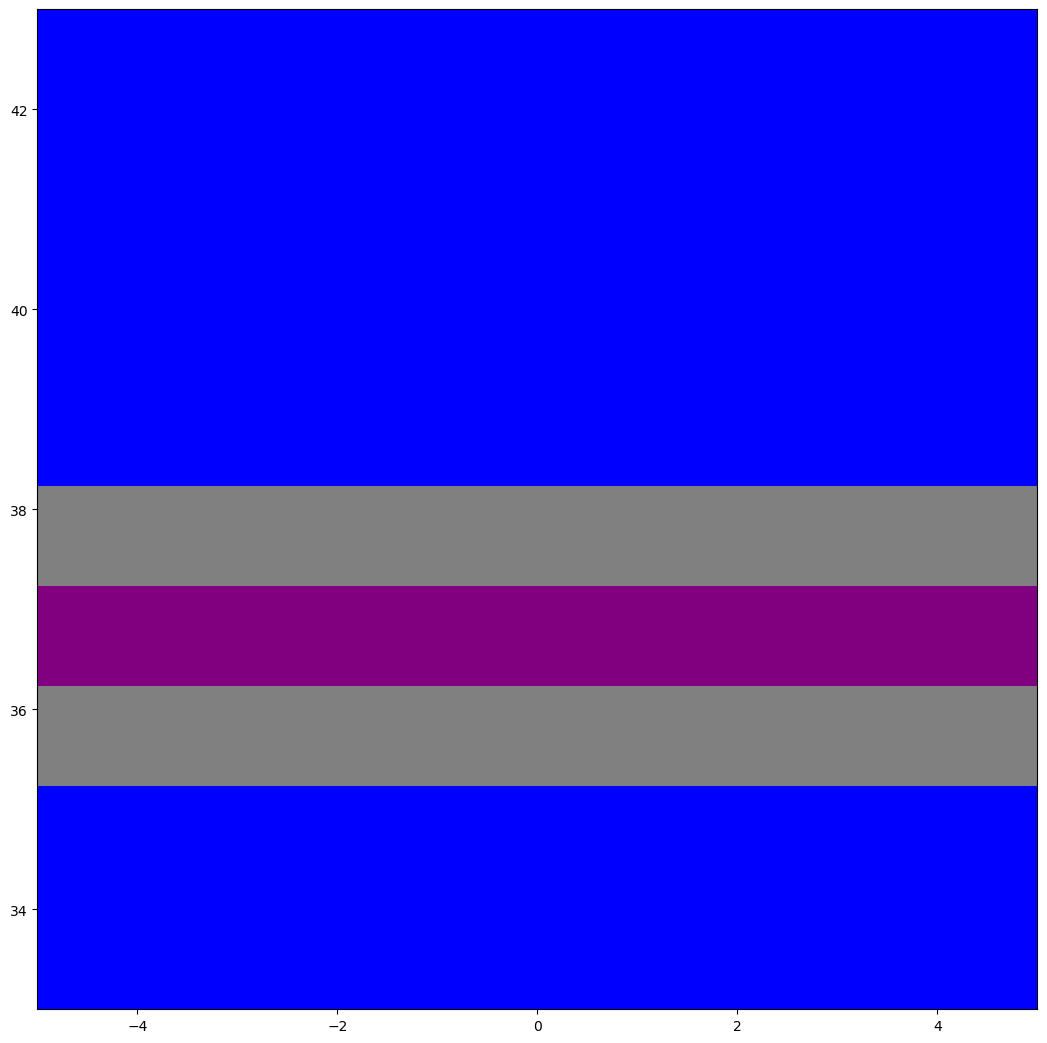

In [6]:
# plot root universe

colors = {}
colors[water]='blue'
colors[pipe]='gray'
colors[target]='purple'
root_univ.plot(origin=(0,0,38),width=(width,10),
               pixels=(1000,1000),color_by='material',
               basis='yz',colors=colors)

Add some tallies.

In [7]:
# create tallies

cell_filter = openmc.CellFilter(c4); # measure in the target material cell


# energy bins
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

# establish a flux tally for the target
flux_target = openmc.Tally(name='flux in target');
flux_target.scores = ['flux'];
flux_target.filters = [cell_filter,energy_filter];

# create a tally to estimate rate of conversion of Np-237 to Np-238
np237_capture_t = openmc.Tally(name='Np237_total_capture');
np237_capture_t.scores = ['(n,gamma)'];
np237_capture_t.nuclides=['Np237'];
efilter_values = [0.0, 1.0, 3.0e4, 14.0e6]; #OpenMC energy units are in eV
efilter_capture = openmc.EnergyFilter(values=efilter_values);
np237_capture_t.filters = [cell_filter,efilter_capture]

# tally fission in Np238
np238_fission_t = openmc.Tally(name='Np238_fiss')
np238_fission_t.scores = ['fission']
np238_fission_t.nuclides = ['Np238']
np238_fission_t.filters = [cell_filter,efilter_capture]

# tally (n,2n) in Np237
np237_n2n_t = openmc.Tally(name='Np237_n2n')
np237_n2n_t.scores = ['(n,2n)']
np237_n2n_t.nuclides = ['Np237']
np237_n2n_t.filters = [cell_filter]

# tally fission in Np237
np237_fission_t = openmc.Tally(name='Np237_fiss')
np237_fission_t.scores = ['fission']
np237_fission_t.nuclides = ['Np237']
np237_fission_t.filters = [cell_filter]


# tally fission in Pu-238
pu238_fission_t = openmc.Tally(name='Pu238_fiss')
pu238_fission_t.scores = ['fission']
pu238_fission_t.nuclides = ['Pu238']
pu238_fission_t.filters = [cell_filter]

# tally (n,gamma) in Pu-238
pu238_capture_t = openmc.Tally(name='Pu238_capture')
pu238_capture_t.scores = ['(n,gamma)']
pu238_capture_t.nuclides = ['Pu238']
pu238_capture_t.filters = [cell_filter]

# tally "total nuclear heating"
heating_t = openmc.Tally(name='heating_t')
heating_t.scores=['heating']
heating_t.filters = [cell_filter]

# tally kappa-fission
kappa_fission_t = openmc.Tally(name='kappa_fission_t')
kappa_fission_t.scores = ['kappa-fission']
kappa_fission_t.filters = [cell_filter]

tallies = openmc.Tallies([ flux_target, np237_capture_t, np237_n2n_t,
                         np238_fission_t, pu238_fission_t, pu238_capture_t,
                         heating_t, kappa_fission_t,np237_fission_t]);
#tallies = openmc.Tallies([ flux_target, np237_capture_t, np237_n2n_t]);
tallies.export_to_xml()

In [8]:
model = openmc.model.Model(geometry,materials,settings,tallies)
operator = openmc.deplete.CoupledOperator(model,chain_file="chain_casl_pwr.xml",
                                         normalization_mode='source-rate');

# Assume a flux of 1e14 n/cm^2-s
avg_flux = 1.0e15; # n/cm^2-s
source_rate = height*width*avg_flux; # n/s
days = 24*3600;
time_steps = [0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.5*days, 0.5*days,
              1.0*days, 1.0*days, 1.0*days, 1.0*days, 4.0*days, 4.0*days, 
              4.0*days, 4.0*days,4.0*days, 4*days, 4*days, 4*days,4*days,
             30*days, 30*days, 180*days, 180*days, 365*days];

cecm = openmc.deplete.PredictorIntegrator(operator,time_steps,
                                    source_rates=source_rate);


repeat_depletion = True;

if(repeat_depletion):
    cecm.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo94 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo94.h5
 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5


 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd106.h5
 Reading Pd107 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd107.h5
 Reading Pd108 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd108.h5
 Reading Ag107 from /home/sblair/OMC_DATA/endfb71_hdf5/Ag107.h5
 Reading Ag109 from /home/sblair/OMC_DAT

 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5


          1200K
          2500K


 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce143.h5
 Reading Ce144 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce144.h5
 Reading Pr141 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr141.h5
 Reading Pr142 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr142.h5
 Reading Pr143 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr143.h5
 Reading Nd142 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd142.h5
 Reading Nd143 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd143.h5
 Reading Nd144 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd144.h5
 Reading Nd145 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd145.h5
 Reading Nd146 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd146.h5
 Reading Nd147 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy163.h5
 Reading Dy164 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy164.h5
 Reading Ho165 from /home/sblair/OMC_DATA/endfb71_hdf5/Ho165.h5
 Reading Er162 from /home/sblair/OMC_DAT

 Simulating batch 33
 Simulating batch 34
 Simulating batch 35
 Simulating batch 36
 Simulating batch 37
 Simulating batch 38
 Simulating batch 39
 Simulating batch 40
 Simulating batch 41
 Simulating batch 42
 Simulating batch 43
 Simulating batch 44
 Simulating batch 45
 Simulating batch 46
 Simulating batch 47
 Simulating batch 48
 Simulating batch 49
 Simulating batch 50
 Simulating batch 51
 Simulating batch 52
 Simulating batch 53
 Simulating batch 54
 Simulating batch 55
 Simulating batch 56
 Simulating batch 57
 Simulating batch 58
 Simulating batch 59
 Simulating batch 60
 Simulating batch 61
 Simulating batch 62
 Simulating batch 63
 Simulating batch 64
 Simulating batch 65
 Simulating batch 66
 Simulating batch 67
 Simulating batch 68
 Simulating batch 69
 Simulating batch 70
 Simulating batch 71
 Simulating batch 72
 Simulating batch 73
 Simulating batch 74
 Simulating batch 75
 Simulating batch 76
 Simulating batch 77
 Simulating batch 78
 Simulating batch 79
 Simulating b

[openmc.deplete] t=86400.0 s, dt=43200.0 s, source=1e+17
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Simulating batch 11
 Simulating batch 12
 Simulating batch 13
 Simulating batch 14
 Simulating batch 15
 Simulating batch 16
 Simulating batch 17
 Simulating batch 18
 Simulating batch 19
 Simulating batch 20
 Simulating batch 21
 Simulating batch 22
 Simulating batch 23
 Simulating batch 24
 Simulating batch 25
 Simulating batch 26
 Simulating batch 27
 Simulating batch 28
 Simulating batch 29
 Simulating batch 30
 Simulating batch 31
 Simulating batch 32
 Simulating batch 33
 Simulating batch 34
 Simulating batch 35
 Simulating batch 36
 Simulating batch 37
 Simulating batch 38
 Simulating batch 39


 Simulating batch 83
 Simulating batch 84
 Simulating batch 85
 Simulating batch 86
 Simulating batch 87
 Simulating batch 88
 Simulating batch 89
 Simulating batch 90
 Simulating batch 91
 Simulating batch 92
 Simulating batch 93
 Simulating batch 94
 Simulating batch 95
 Simulating batch 96
 Simulating batch 97
 Simulating batch 98
 Simulating batch 99
 Simulating batch 100
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 1.4146e+01 seconds
   Time in transport only          = 1.3428e+01 seconds
   Time in active batches          = 1.4146e+01 seconds
   Time accumulating tallies       = 6.9082e-01 seconds
   Time writing statepoints        = 1.5959e-02 seconds
 Total time for finalization       = 2.2952e-03 seconds
 Total time elapsed                = 1.4395e+01 sec

 Simulating batch 25
 Simulating batch 26
 Simulating batch 27
 Simulating batch 28
 Simulating batch 29
 Simulating batch 30
 Simulating batch 31
 Simulating batch 32
 Simulating batch 33
 Simulating batch 34
 Simulating batch 35
 Simulating batch 36
 Simulating batch 37
 Simulating batch 38
 Simulating batch 39
 Simulating batch 40
 Simulating batch 41
 Simulating batch 42
 Simulating batch 43
 Simulating batch 44
 Simulating batch 45
 Simulating batch 46
 Simulating batch 47
 Simulating batch 48
 Simulating batch 49
 Simulating batch 50
 Simulating batch 51
 Simulating batch 52
 Simulating batch 53
 Simulating batch 54
 Simulating batch 55
 Simulating batch 56
 Simulating batch 57
 Simulating batch 58
 Simulating batch 59
 Simulating batch 60
 Simulating batch 61
 Simulating batch 62
 Simulating batch 63
 Simulating batch 64
 Simulating batch 65
 Simulating batch 66
 Simulating batch 67
 Simulating batch 68
 Simulating batch 69
 Simulating batch 70
 Simulating batch 71
 Simulating b

[openmc.deplete] t=1209600.0 s, dt=345600.0 s, source=1e+17
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Simulating batch 11
 Simulating batch 12
 Simulating batch 13
 Simulating batch 14
 Simulating batch 15
 Simulating batch 16
 Simulating batch 17
 Simulating batch 18
 Simulating batch 19
 Simulating batch 20
 Simulating batch 21
 Simulating batch 22
 Simulating batch 23
 Simulating batch 24
 Simulating batch 25
 Simulating batch 26
 Simulating batch 27
 Simulating batch 28
 Simulating batch 29
 Simulating batch 30
 Simulating batch 31
 Simulating batch 32
 Simulating batch 33
 Simulating batch 34
 Simulating batch 35
 Simulating batch 36
 Simulating batch 37
 Simulating batch 38
 Simulating batch 

 Simulating batch 83
 Simulating batch 84
 Simulating batch 85
 Simulating batch 86
 Simulating batch 87
 Simulating batch 88
 Simulating batch 89
 Simulating batch 90
 Simulating batch 91
 Simulating batch 92
 Simulating batch 93
 Simulating batch 94
 Simulating batch 95
 Simulating batch 96
 Simulating batch 97
 Simulating batch 98
 Simulating batch 99
 Simulating batch 100
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 1.3726e+01 seconds
   Time in transport only          = 1.3307e+01 seconds
   Time in active batches          = 1.3726e+01 seconds
   Time accumulating tallies       = 3.9648e-01 seconds
   Time writing statepoints        = 1.5862e-02 seconds
 Total time for finalization       = 1.7541e-03 seconds
 Total time elapsed                = 1.3972e+01 sec

 Simulating batch 23
 Simulating batch 24
 Simulating batch 25
 Simulating batch 26
 Simulating batch 27
 Simulating batch 28
 Simulating batch 29
 Simulating batch 30
 Simulating batch 31
 Simulating batch 32
 Simulating batch 33
 Simulating batch 34
 Simulating batch 35
 Simulating batch 36
 Simulating batch 37
 Simulating batch 38
 Simulating batch 39
 Simulating batch 40
 Simulating batch 41
 Simulating batch 42
 Simulating batch 43
 Simulating batch 44
 Simulating batch 45
 Simulating batch 46
 Simulating batch 47
 Simulating batch 48
 Simulating batch 49
 Simulating batch 50
 Simulating batch 51
 Simulating batch 52
 Simulating batch 53
 Simulating batch 54
 Simulating batch 55
 Simulating batch 56
 Simulating batch 57
 Simulating batch 58
 Simulating batch 59
 Simulating batch 60
 Simulating batch 61
 Simulating batch 62
 Simulating batch 63
 Simulating batch 64
 Simulating batch 65
 Simulating batch 66
 Simulating batch 67
 Simulating batch 68
 Simulating batch 69
 Simulating b

[openmc.deplete] t=6220800.0 s, dt=2592000.0 s, source=1e+17
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Simulating batch 11
 Simulating batch 12
 Simulating batch 13
 Simulating batch 14
 Simulating batch 15
 Simulating batch 16
 Simulating batch 17
 Simulating batch 18
 Simulating batch 19
 Simulating batch 20
 Simulating batch 21
 Simulating batch 22
 Simulating batch 23
 Simulating batch 24
 Simulating batch 25
 Simulating batch 26
 Simulating batch 27
 Simulating batch 28
 Simulating batch 29
 Simulating batch 30
 Simulating batch 31
 Simulating batch 32
 Simulating batch 33
 Simulating batch 34
 Simulating batch 35
 Simulating batch 36
 Simulating batch 37
 Simulating batch 38
 Simulating batch

 Simulating batch 82
 Simulating batch 83
 Simulating batch 84
 Simulating batch 85
 Simulating batch 86
 Simulating batch 87
 Simulating batch 88
 Simulating batch 89
 Simulating batch 90
 Simulating batch 91
 Simulating batch 92
 Simulating batch 93
 Simulating batch 94
 Simulating batch 95
 Simulating batch 96
 Simulating batch 97
 Simulating batch 98
 Simulating batch 99
 Simulating batch 100
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 1.3938e+01 seconds
   Time in transport only          = 1.3311e+01 seconds
   Time in active batches          = 1.3938e+01 seconds
   Time accumulating tallies       = 6.0277e-01 seconds
   Time writing statepoints        = 1.5523e-02 seconds
 Total time for finalization       = 1.9998e-03 seconds
 Total time elapsed           

In [9]:
results = openmc.deplete.Results('./depletion_results.h5')

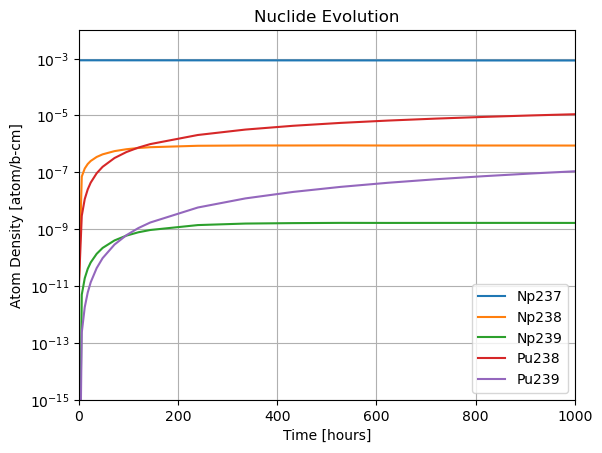

In [10]:
# check the materials.xml file to get the material number for the target
time, np237 = results.get_atoms("3","Np237",nuc_units="atom/b-cm",
                               time_units="h")
time, np238 = results.get_atoms("3","Np238",nuc_units="atom/b-cm",
                               time_units="h")
time, np239 = results.get_atoms("3","Np239",nuc_units="atom/b-cm",
                               time_units="h")
time, pu238 = results.get_atoms("3","Pu238",nuc_units="atom/b-cm",
                                time_units="h")
time, pu239 = results.get_atoms("3","Pu239",nuc_units="atom/b-cm",
                               time_units="h")

time, pu240 = results.get_atoms("3","Pu240",nuc_units="atom/b-cm",
                                time_units="h")
time, pu241 = results.get_atoms("3","Pu241",nuc_units="atom/b-cm",
                               time_units="h")
time, pu242 = results.get_atoms("3","Pu242",nuc_units="atom/b-cm",
                               time_units="h")


plt.semilogy(time,np237,label="Np237")
plt.semilogy(time,np238,label="Np238")
plt.semilogy(time,np239,label="Np239")
plt.semilogy(time,pu238,label="Pu238")
plt.semilogy(time,pu239,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Atom Density [atom/b-cm]")
plt.grid()
plt.axis([0,1000,1e-15,1e-2])
plt.legend()

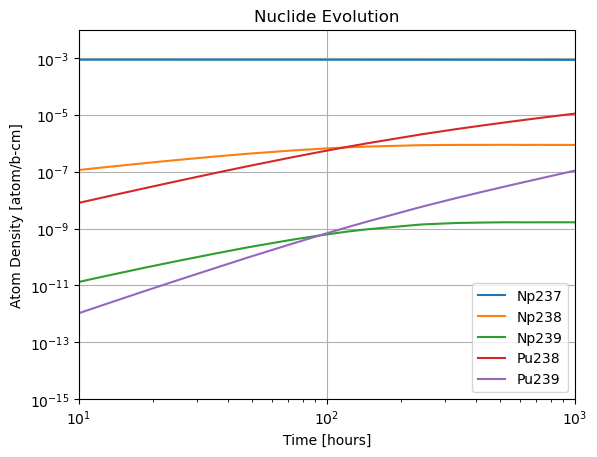

In [11]:
# repeat with loglog plot.

plt.loglog(time,np237,label="Np237")
plt.loglog(time,np238,label="Np238")
plt.loglog(time,np239,label="Np239")
plt.loglog(time,pu238,label="Pu238")
plt.loglog(time,pu239,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Atom Density [atom/b-cm]")
plt.grid()
plt.axis([10,1000,1e-15,1e-2])
plt.legend()

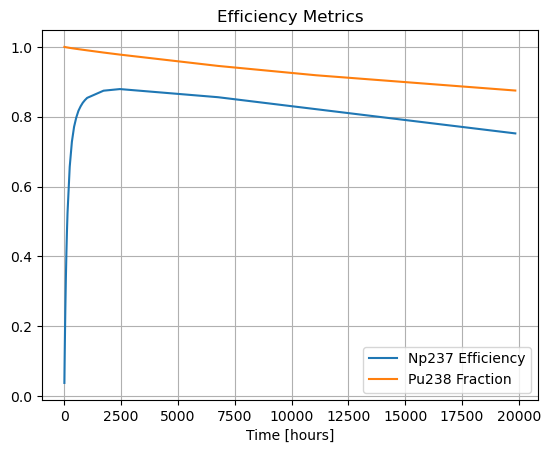

In [12]:
# plot cumulative increase of Pu-238 / cumulative use of Np-237 (metric1)
# and ratio of Pu-238 / all Pu (metric2)

change_np237 = np237[0] - np237[1:]
change_pu238 = pu238[1:] - pu238[0]
metric1 = change_pu238/change_np237

allPu = pu238 + pu239 + pu240 + pu241 + pu242

metric2 = pu238[1:]/allPu[1:]

plt.plot(time[1:],metric1,label="Np237 Efficiency")
plt.plot(time[1:],metric2,label="Pu238 Fraction")
plt.title("Efficiency Metrics")
plt.xlabel("Time [hours]")
plt.grid()
plt.legend()


In [13]:
print(allPu)

[8.67047317e-12 2.93802281e-09 1.14230469e-08 2.50100078e-08
 4.32564194e-08 9.22081747e-08 1.55679027e-07 3.17664169e-07
 5.15216078e-07 7.38645345e-07 9.80817346e-07 2.05399780e-06
 3.19121317e-06 4.33847462e-06 5.48987634e-06 6.63738741e-06
 7.78392041e-06 8.92945215e-06 1.00727614e-05 1.12127545e-05
 1.97243451e-05 2.81100746e-05 7.56597125e-05 1.18578251e-04
 1.91307110e-04]


In [14]:
print(pu238)

[8.67047316e-12 2.93779074e-09 1.14212446e-08 2.50041117e-08
 4.32429193e-08 9.21656483e-08 1.55583560e-07 3.17376887e-07
 5.14602736e-07 7.37555706e-07 9.79105187e-07 2.04822227e-06
 3.17911765e-06 4.31803505e-06 5.45906032e-06 6.59431453e-06
 7.72668467e-06 8.85612332e-06 9.98147024e-06 1.11017017e-05
 1.94051121e-05 2.74896689e-05 7.15357385e-05 1.08936586e-04
 1.67388972e-04]


In [15]:
times, np237_abs_rates = results.get_reaction_rate('3','Np237','(n,gamma)')
times, np237_fiss_rates = results.get_reaction_rate('3','Np237','fission')
times, np237_n2n_rates = results.get_reaction_rate('3','Np237','(n,2n)')

In [16]:
nSteps = 25; # number of burnup steps
# make arrays to hold reaction rate tally data

np238f = np.zeros([nSteps,],dtype=np.float64);
np237n2n = np.zeros_like(np238f);
pu238f = np.zeros_like(np238f);
pu238c = np.zeros_like(np238f);

nuc_heating = np.zeros_like(np238f);
kappa_fission = np.zeros_like(np238f);

np237f = np.zeros_like(np238f);

eV_to_kJ = 1.60218e-22; # convert eV to kJ


name_stub = "openmc_simulation_n";
name_suffix = ".h5"

# populate the arrays
for n in range(nSteps):
    fn = name_stub + str(n) + name_suffix # assemble the filename
    sp = openmc.StatePoint(fn); # open the statepoint file
    
    # read the tallies and populate associated numpy arrays
    t1 = sp.get_tally(name="Np238_fiss");
    t1_df = t1.get_pandas_dataframe()
    np238f[n] = t1_df['mean'][0];
    
    t2 = sp.get_tally(name="Np237_n2n");
    t2_df = t2.get_pandas_dataframe();
    np237n2n[n] = t2_df['mean'][0];
    
    t3 = sp.get_tally(name="Pu238_fiss");
    t3_df = t3.get_pandas_dataframe();
    pu238f[n] = t3_df['mean'][0];
    
    t4 = sp.get_tally(name="Pu238_capture");
    t4_df = t4.get_pandas_dataframe();
    pu238c[n] = t4_df['mean'][0];
    
    t5 = sp.get_tally(name="heating_t");
    t5_df = t5.get_pandas_dataframe();
    nuc_heating[n] = t5_df['mean'][0]*source_rate*eV_to_kJ;
    
    t6 = sp.get_tally(name="kappa_fission_t");
    t6_df = t6.get_pandas_dataframe();
    kappa_fission[n] = t6_df['mean'][0]*source_rate*eV_to_kJ;
    
    t7 = sp.get_tally(name="Np237_fiss");
    t7_df = t7.get_pandas_dataframe();
    np237f[n] = t7_df['mean'][0];
    
    sp.close(); # close the statepoint file
    
   

In [17]:
np238f.size

25

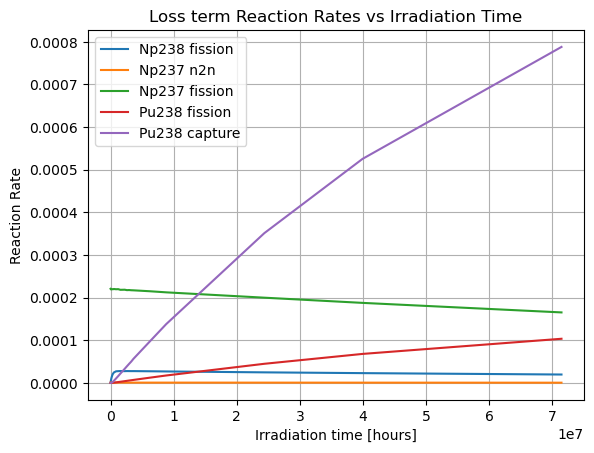

In [18]:
plt.plot(times,np238f,label='Np238 fission')
plt.plot(times,np237n2n,label='Np237 n2n');
plt.plot(times,np237f,label='Np237 fission')
plt.plot(times,pu238f,label='Pu238 fission')
plt.plot(times,pu238c, label='Pu238 capture')
plt.grid()
plt.legend()
plt.xlabel('Irradiation time [hours]')
plt.ylabel('Reaction Rate')
plt.title('Loss term Reaction Rates vs Irradiation Time');

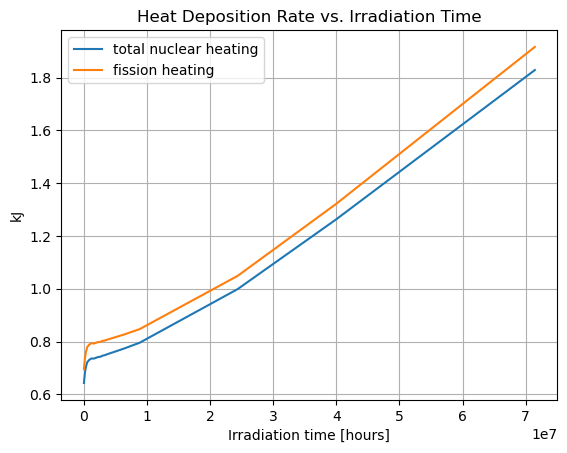

In [19]:
plt.plot(times,nuc_heating,label='total nuclear heating')
plt.plot(times,kappa_fission,label='fission heating')
plt.grid()
plt.legend()
plt.xlabel('Irradiation time [hours]')
plt.ylabel('kJ')
plt.title('Heat Deposition Rate vs. Irradiation Time');

In [2]:
sp = openmc.StatePoint('openmc_simulation_n24.h5')

avg_flux = sp.get_tally(name='avg flux')
avg_flux_df = avg_flux.get_pandas_dataframe();
avg_flux_vals = avg_flux_df['mean'].to_numpy();

energy_x = 0.5*(energy_bins[0:-1] + energy_bins[1:]);

plt.loglog(energy_x,avg_flux_vals);
plt.grid();
plt.xlabel('Energy [eV]');
plt.ylabel('flux [n/cm**2-s]');

NameError: name 'openmc' is not defined